# Model Analysis - Conservation

In [1]:
import os, sys
import scipy
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib import rc

mpl.rcParams['pdf.fonttype'] = 42

from matplotlib.ticker import ScalarFormatter
%matplotlib inline

## Constants

In [2]:
#############################
#                           #
#                           #
#        CONSTANTS          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
OUTPUT_DIR = LOCAL_DIR+'/figures/model_analysis_conservation'
if not os.path.exists(OUTPUT_DIR): os.mkdir(OUTPUT_DIR)

In [3]:
from importlib import reload
if LOCAL_DIR not in sys.path: 
    sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

## Load Data

In [4]:
#load all sequence designs
tested_sequences = FHS.get_sequences_df()

#load the natural MSA used to generate the model
msa_df = FHS.get_natural_msa_df(remove_unaligned_positions=False)

In [5]:
#munge the multiple sequence alignment so that the column name 
#is the aligned position (as a string) and each row is a single natural
#sequence with one amino acid per column. Unaligned positions, which
#have an nan model number are removed.
def split_msa_seqs():
    toreturn = {}
    numbering_df = FHS.get_numbering_df()
    
    #iterate columns and extract seqs
    for idx in range(0, len(msa_df.iloc[0].seq)): 
        model_num = numbering_df[
            numbering_df.model_full_seq_idx == idx
        ].iloc[0].model_num
        
        if not pd.isna(model_num):
            toreturn[int(model_num)] = msa_df.seq.apply(
                lambda x: x[idx]
            )

    return pd.DataFrame(toreturn)
msa_split_df = split_msa_seqs()

## Data Analysis

In [6]:
def get_entropy_conservation_df(aa_counts_df):
    '''
    calculate the entropy and conservation of each position, both
    with and without the aligned sequences
    '''
    toreturn = {
        'model_num': [],
        'shannon_entropy': [],
        'shannon_entropies_w_dash': [],
    }

    without_dashes_df = aa_counts_df.drop('-')
    for model_num, counts in without_dashes_df.items():
        toreturn['model_num'].append(model_num)
        
        frequencies = counts / np.sum(counts)
        entropy = scipy.stats.entropy(frequencies)

        toreturn['shannon_entropy'].append(entropy)

    for model_num, counts in aa_counts_df.items():
        frequencies = counts / np.sum(counts)
        entropy = scipy.stats.entropy(frequencies)
        
        toreturn['shannon_entropies_w_dash'].append(entropy)

    toreturn = pd.DataFrame(toreturn)
    toreturn['conservation'] = np.max(toreturn['shannon_entropy']) - toreturn['shannon_entropy']
    toreturn['conservation_w_dash'] = np.max(toreturn['shannon_entropies_w_dash']) - toreturn['shannon_entropies_w_dash']
    
    return toreturn
    
entropy_conservation_df = get_entropy_conservation_df(
    #count the amino acids in each column
    msa_split_df.apply(
        lambda row: row.value_counts()
    ).fillna(0)
)

## Plotting

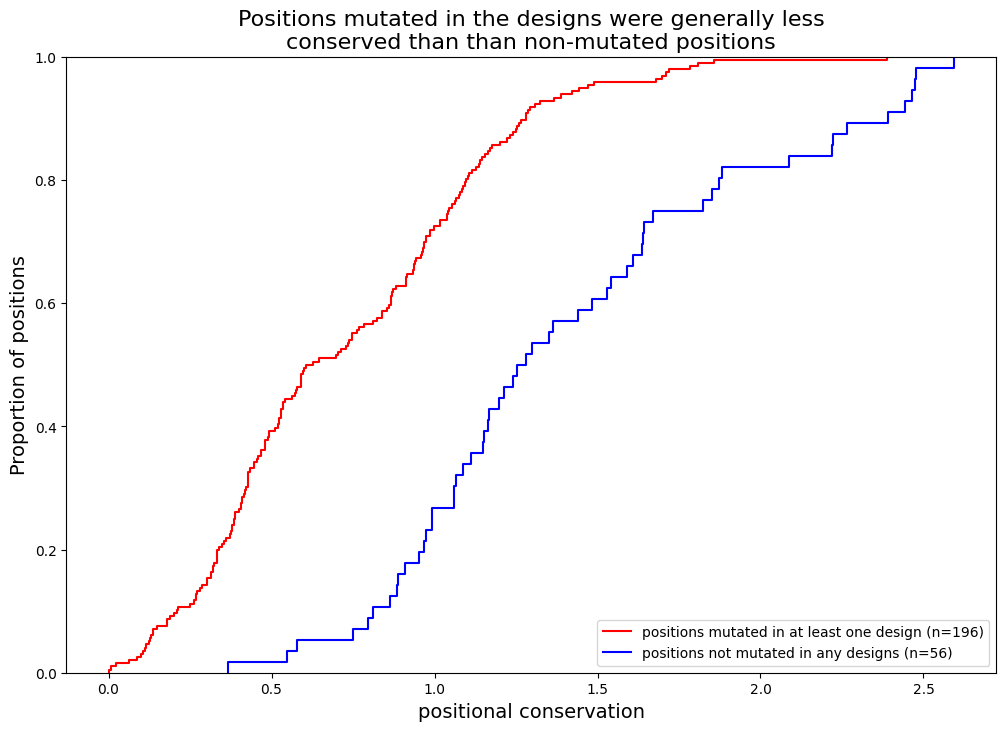

In [7]:
def plot_conservation():
    mutated_model_positions = list(
        tested_sequences[
            tested_sequences.is_design==1
        ].model_mutations.explode().apply(
            lambda mut: int(mut[1:-1])
        ).unique()
    )

    mutated_conservation_df = entropy_conservation_df[
        entropy_conservation_df.model_num.isin(mutated_model_positions)
    ]

    nonmutated_conservation_df = entropy_conservation_df[
        ~entropy_conservation_df.model_num.isin(mutated_model_positions)
    ]


    #plot
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(12, 8)
    sns.ecdfplot(
        data=mutated_conservation_df, 
        x='conservation', color='red', ax=ax, 
        label='positions mutated in at least one design (n={0})'.format(len(
            mutated_conservation_df
        ))
    )
    sns.ecdfplot(
        data=nonmutated_conservation_df, 
        x='conservation', color='blue', ax=ax,
        label='positions not mutated in any designs (n={0})'.format(len(
            nonmutated_conservation_df
        ))
    )

    #decorate
    ax.set_title(
        'Positions mutated in the designs were generally less\n'+
        'conserved than than non-mutated positions',
        fontsize=16
    )
    ax.set_ylabel('Proportion of positions', fontsize=14)
    ax.set_xlabel(
        'positional conservation', 
        fontsize=14
    )
    ax.legend(loc='lower right')
    fig.savefig(OUTPUT_DIR+'/model_analysis_conservation.pdf')

plot_conservation()

# MISC

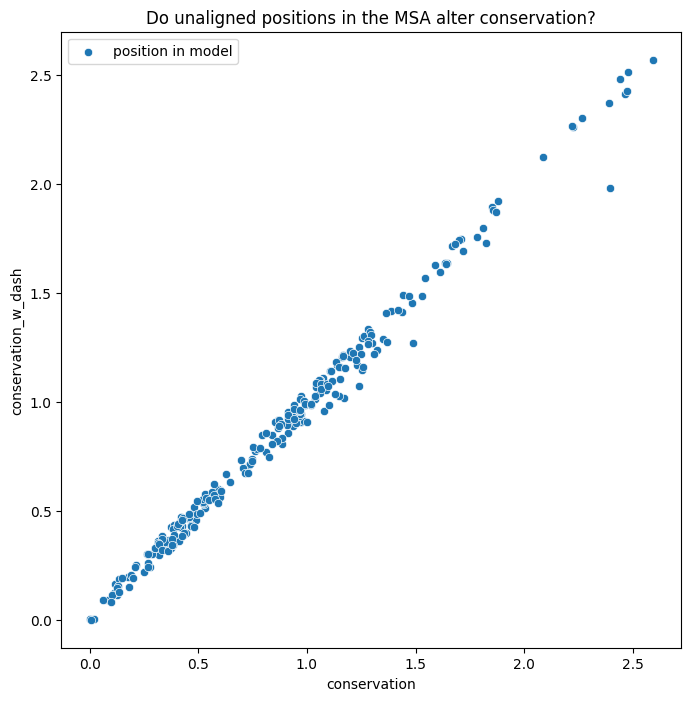

In [8]:
#do the dashes matter to conservation? 
#conclusion: not really although there are a couple outliers
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8)
sns.scatterplot(
    data=entropy_conservation_df, 
    x='conservation', y='conservation_w_dash',
    label='position in model', ax=ax
)
ax.legend()
null = ax.set_title('Do unaligned positions in the MSA alter conservation?')

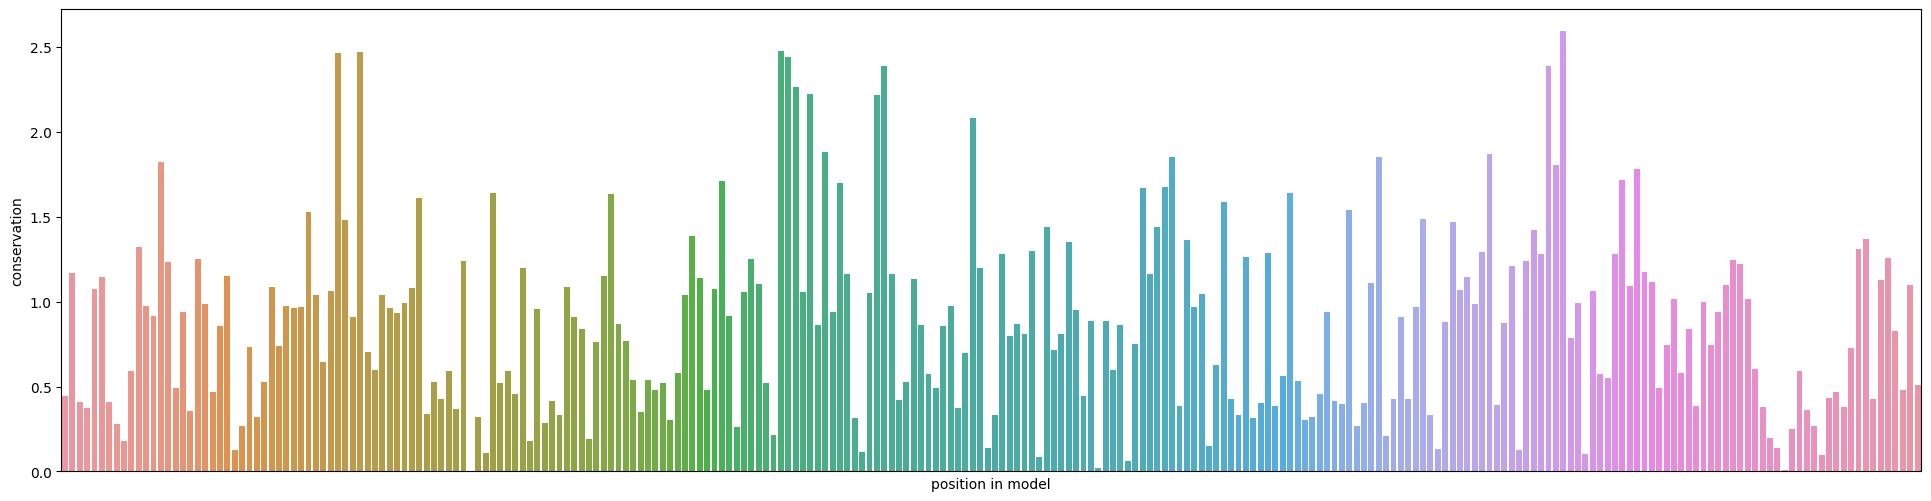

In [9]:
#sanity check that conservation matches the MSA calculated 
#on fast.alignmentviewer.org
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
sns.barplot(data=entropy_conservation_df, 
            x='model_num', y='conservation', 
            ax=ax)
ax.set_xticks([])
null = ax.set_xlabel('position in model')